# Lasso with KNN PCA

Lasso (short for Least Absolute Shrinkage and Selection Operator) is a linear regression technique that is commonly used for feature selection and regularization.

Principal Component Analysis (PCA) is a widely used technique in machine learning and data science for dimensionality reduction.

As stock data is time series data, there are a lot of noise which may affect the performance of the model. Therefore, we use PCA to reduce the dimension of the data and Lasso to select the features.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV,LassoLarsCV,Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,mean_squared_error
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt

import sys
from scipy.sparse import dia_matrix
import scipy.sparse.linalg
import math
from pca import pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fancyimpute import KNN
from sklearn.impute import KNNImputer
warnings.filterwarnings("ignore",category=ConvergenceWarning)

In [6]:
# small test 
def knnpca(df, k=5, n_components = 3):
    features = list(df.columns[0:])
    # print(len(features))
    x = df.loc[:,features].values
    x = StandardScaler().fit_transform(x)
    imputer = KNN(k, verbose=False)
    x = imputer.fit_transform(x)
    pca = PCA(n_components)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['PC{}'.format(i) for i in range(1, n_components+1)])
    
        # Get the explained variance for each component
    explained_var = pca.explained_variance_ratio_

    # Calculate the cumulative explained variance
    cumulative_var = np.cumsum(explained_var)

    # Plot the cumulative explained variance// To avoid redundant, this part is commented after CEV is plotted
    # plt.plot(range(1, n_components+1), cumulative_var, '-o')
    # plt.xlabel('Number of components')
    # plt.ylabel('Cumulative explained variance')
    # plt.title('Cumulative Explained Variance')
    # plt.show()
    
    return principalDf



We want to abandon as most noise as possible but still keep the interpretabilities, so we draw the CEV to decide the best number of components, which is 30. So the result 30 components could interpret 99.9% of the data but also kick off most noise. In addition, some data is missing here so we use KNN to impute the missing data before we do PCA.

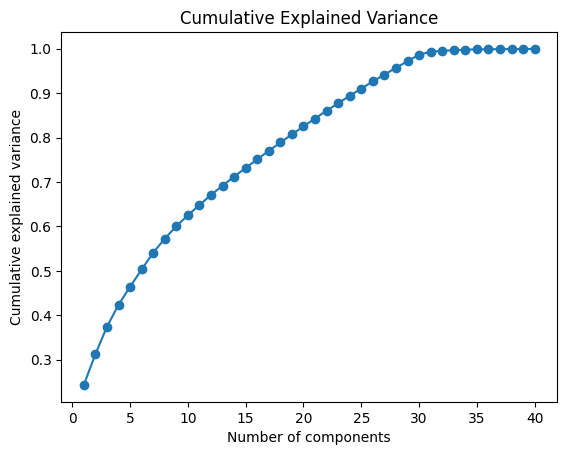

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,-4.676183,0.717328,-3.916821,-0.865202,0.423330,2.126407,2.989734,0.572820,0.663627,0.446939,...,-0.638703,0.319669,-0.314367,0.063588,-0.157860,0.015142,0.021906,0.064300,0.002181,0.047385
1,-4.793984,0.903469,-3.945507,-1.064112,-1.683572,1.632482,-2.088154,0.717673,0.613422,0.464931,...,-0.632267,0.343135,-0.313338,0.029663,-0.141558,-0.011845,-0.047436,-0.041502,-0.069362,0.058466
2,-5.020662,1.230514,-3.873630,-1.392689,1.928160,-1.131456,-2.776604,-0.295735,0.426009,-0.199288,...,-0.746628,0.303498,-0.309260,0.007566,-0.150675,-0.111592,-0.039737,-0.229231,0.049471,0.080696
3,-5.036326,1.347989,-3.367817,-1.713100,-0.875235,-2.079474,0.093144,-0.026547,0.181758,-0.030956,...,-0.686063,0.157077,-0.305340,0.026791,-0.198118,-0.080892,0.183004,-0.078729,0.113372,0.082364
4,-4.306113,0.691473,-3.390819,-1.370803,-0.895087,-2.646459,1.216676,2.506918,0.343153,-0.312097,...,-0.572702,0.048366,-0.238183,0.002306,-0.211069,-0.021385,0.202773,0.045157,-0.084845,0.073405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,6.949113,-4.233779,0.953912,-1.065472,1.639143,-0.873742,0.991530,1.205190,1.166008,0.212502,...,1.150519,-0.099034,-0.081145,0.415315,-0.322892,0.171621,-0.116997,0.019932,0.124407,0.100919
2512,7.268151,-4.805499,0.901674,-0.768415,-0.341862,0.862394,-0.731504,0.779333,1.227972,2.598307,...,1.284844,-0.181124,-0.067615,0.372019,-0.309546,-0.011639,-0.033359,-0.337693,0.071252,0.102504
2513,6.699623,-4.215744,1.135155,-1.275359,1.356284,0.400320,-0.853101,-0.796311,1.402859,2.157178,...,1.140486,0.033756,-0.091053,0.401800,-0.375607,0.037946,0.296956,-0.112781,0.174765,0.121890
2514,7.205620,-4.765040,1.129899,-1.470075,-1.346731,0.928555,1.203885,0.978552,1.669729,1.751471,...,1.230614,-0.557988,0.004180,0.466260,-0.373960,0.224073,0.052920,0.047310,0.083379,0.145893


In [5]:
# Test for AAPL

freq = 'Daily'
stock = 'AAPL'
price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
price = price.sort_values(by='Date').reset_index(drop=True)
price = price.loc[price.Date>='2010-01-01']
predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv',index_col='Date')
NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv').set_index(['Date'])
predictors = predictors.merge(NLP,left_index=True,right_index=True,how='left')
predictors = predictors.loc[predictors.index<='2019-12-31',:]
knnpca(predictors, k=5, n_components = 40) 

In [7]:
def X_y(freq,stock):
    #freq = 'Daily'
    #stock = 'AAPL'
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.sort_values(by='Date').reset_index(drop=True)
    price = price.loc[price.Date>='2010-01-01']
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv',index_col='Date')
    NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv').set_index(['Date'])
    predictors = predictors.merge(NLP,left_index=True,right_index=True,how='left')
    predictors = predictors.loc[predictors.index<='2019-12-31',:]
    # predictors.fillna(0,inplace=True)
    predictors = knnpca(predictors, k=5, n_components = 30)

    X = predictors.values[:,]
    y = price.adjusted_close.shift(-1).values[:len(X)]

    return X,y

Also, we are not sure about the range of training data and as we want the best performace, we use cross validation to find the best n_splits for each stock.

In [13]:

def mse(y_pred, y_true):
    n = len(y_pred)
    return np.sqrt(np.sum(np.square(y_pred - y_true)))/n

# Find the best split for time series
def find_split(X,y):
    scores = []
    for i in range(3,15):
        tscv = TimeSeriesSplit(n_splits=i)
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
        pipe = make_pipeline(MinMaxScaler(),Lasso())

        sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select='auto',scoring='neg_root_mean_squared_error')
        sfs.fit(X_train,y_train)
        X_train = sfs.transform(X_train)
        pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
        pipmodel.fit(X_train,y_train)
        X_test =  sfs.transform(X_test)
        y_pred = pipmodel.predict(X_train)
        score = mean_squared_error(y_pred, y_train)
        # print(score)
        scores.append(score)
    n_split = scores.index(min(scores))+2
    return n_split

In [17]:
def lasso(X,y,n_split,stock):
    tscv = TimeSeriesSplit(n_splits=n_split)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
    pipe = make_pipeline(MinMaxScaler(),Lasso())
    tscv = TimeSeriesSplit(n_splits=10)
    sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=15,scoring='neg_root_mean_squared_error')
    sfs.fit(X_train,y_train)
    X_train = sfs.transform(X_train)
    pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
    pipmodel.fit(X_train,y_train)
    X_test =  sfs.transform(X_test)
    y_pred = pipmodel.predict(X_test)
    print("Test MSE: ",mse(y_pred, y_test),"Train MSE: ", mse(y_train, pipmodel.predict(X_train)))
    plt.plot(y_pred,label="Predictions")
    plt.plot(y_test,label="Actual Data")
    plt.title(stock)
    plt.legend()
    plt.show()

AAPL / Daily :
Test MSE:  0.4691850414745935 Train MSE:  0.05872271327186681


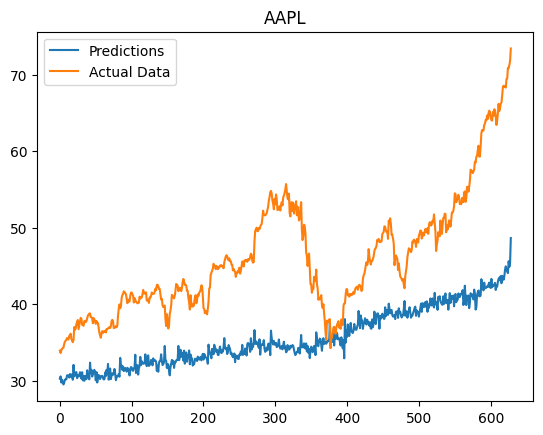

AAPL / Weekly :
Test MSE:  0.9357221223094163 Train MSE:  0.11666992558802879


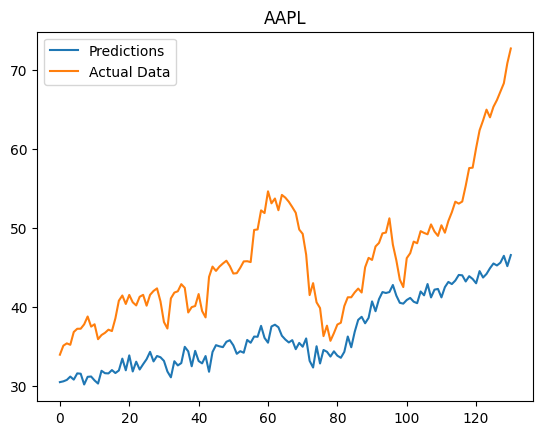

AAPL / Monthly :
Test MSE:  2.2871456798752634 Train MSE:  0.1747547672467321


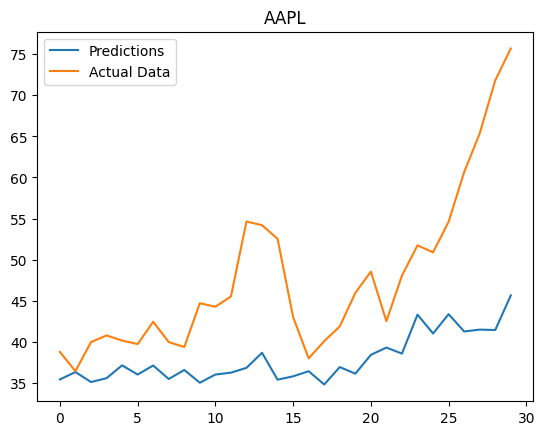

MSFT / Daily :
Test MSE:  0.7026194454036051 Train MSE:  0.057063143102597774


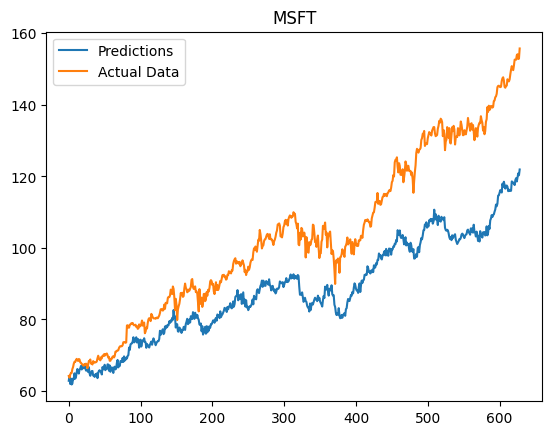

MSFT / Weekly :
Test MSE:  1.762134387794087 Train MSE:  0.11464341389699906


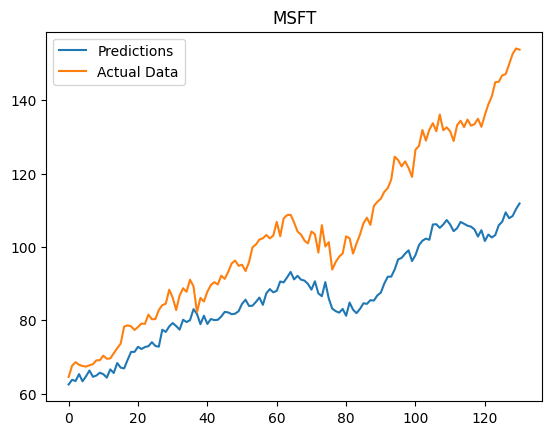

MSFT / Monthly :
Test MSE:  3.2003148807169093 Train MSE:  0.24288496512794772


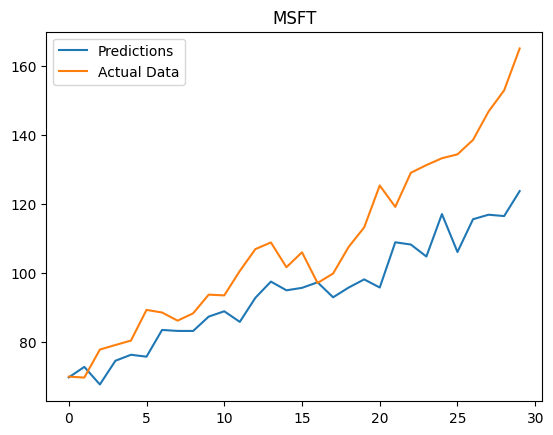

GOOG / Daily :
Test MSE:  0.10705867348610591 Train MSE:  0.040557934815358285


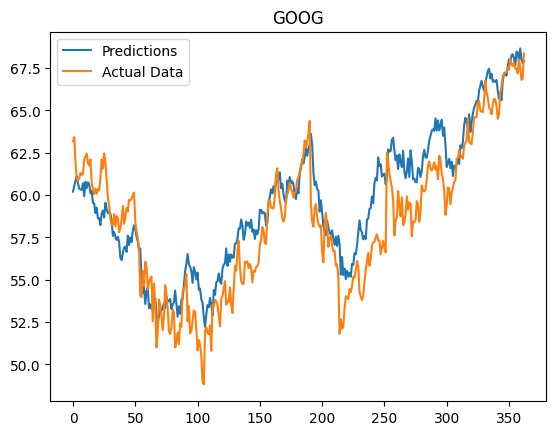

GOOG / Weekly :
Test MSE:  0.23897358798971222 Train MSE:  0.10250226373878321


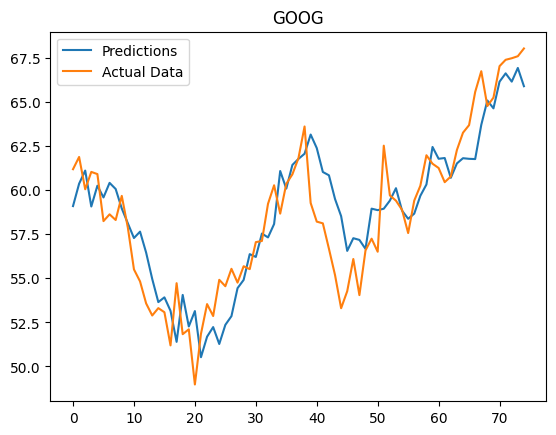

GOOG / Monthly :
Test MSE:  1.1300445335648548 Train MSE:  0.2615970214566666


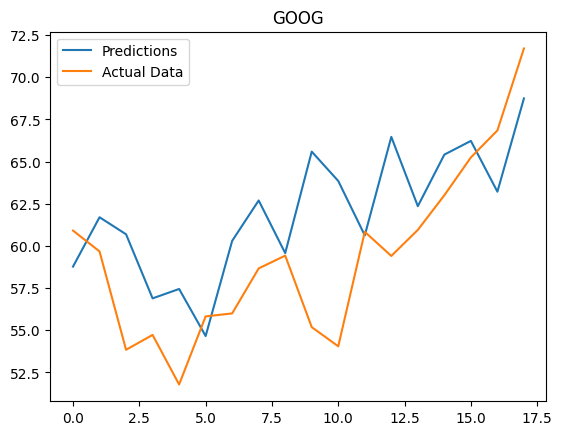

AMZN / Daily :
Test MSE:  0.6004458002751369 Train MSE:  0.0521540073199507


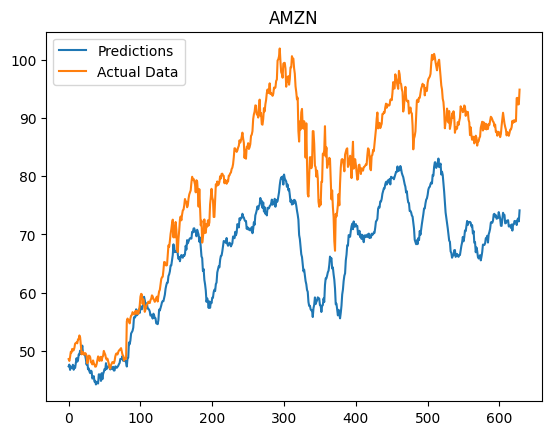

AMZN / Weekly :
Test MSE:  1.292911059067927 Train MSE:  0.08906666741355251


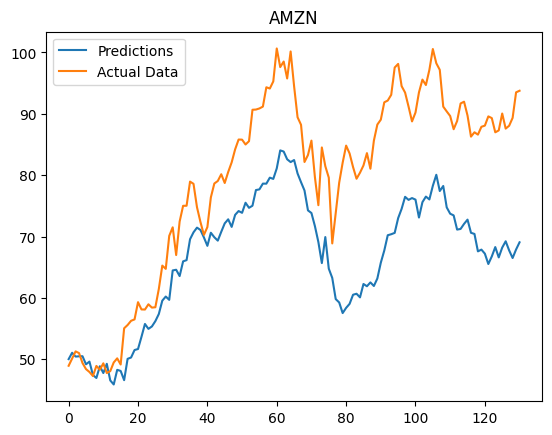

AMZN / Monthly :
Test MSE:  3.192296565231725 Train MSE:  0.2291269380327582


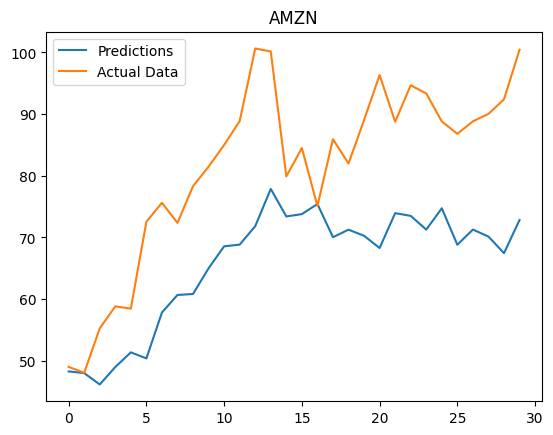

NVDA / Daily :
Test MSE:  0.4019363967207128 Train MSE:  0.03934582200098652


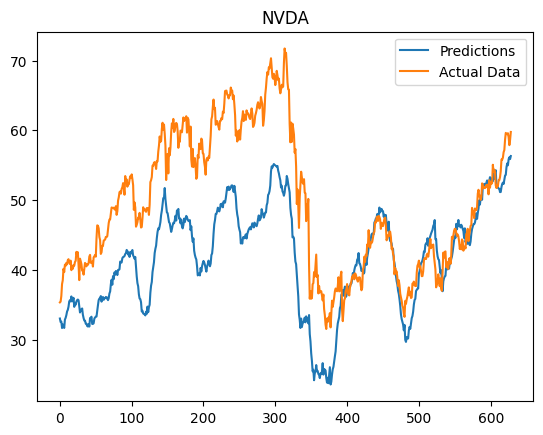

NVDA / Weekly :
Test MSE:  0.8574928949006375 Train MSE:  0.09757049358341095


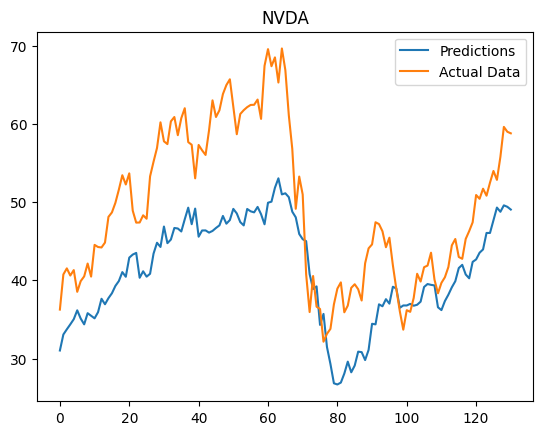

NVDA / Monthly :
Test MSE:  1.800166745263043 Train MSE:  0.2047975753575306


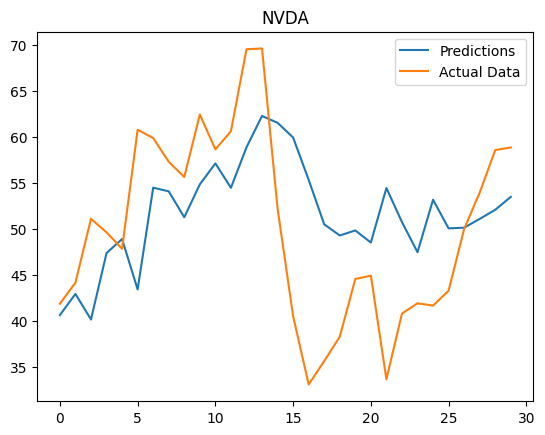

BRK-B / Daily :
Test MSE:  0.45692926111562354 Train MSE:  0.1478215092869009


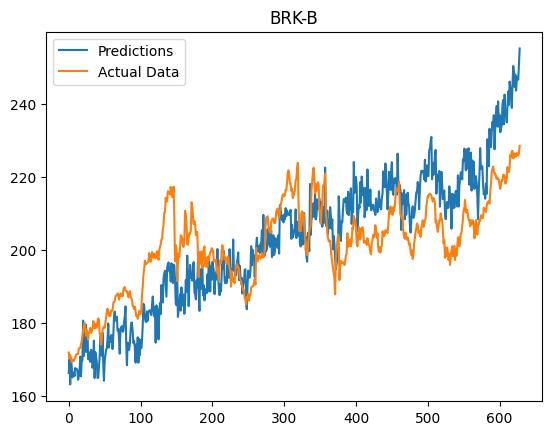

BRK-B / Weekly :
Test MSE:  2.3664889271693177 Train MSE:  0.4449159725727474


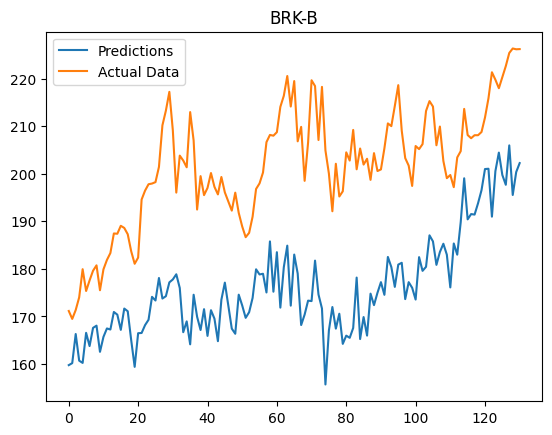

BRK-B / Monthly :
Test MSE:  1.8016573382647778 Train MSE:  0.5654966801856764


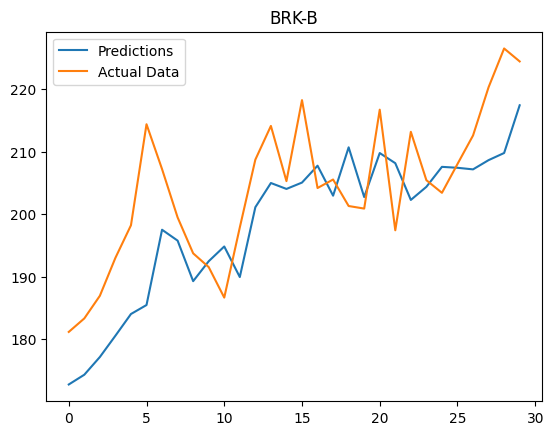

TSLA / Daily :
Test MSE:  0.07114643228567494 Train MSE:  0.024993495424423622


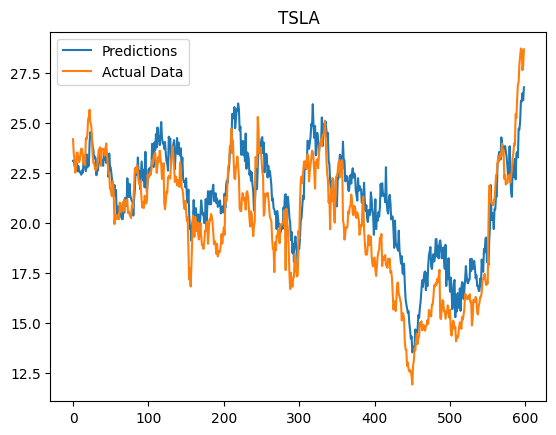

TSLA / Weekly :
Test MSE:  0.2668020520479658 Train MSE:  0.05827484977093573


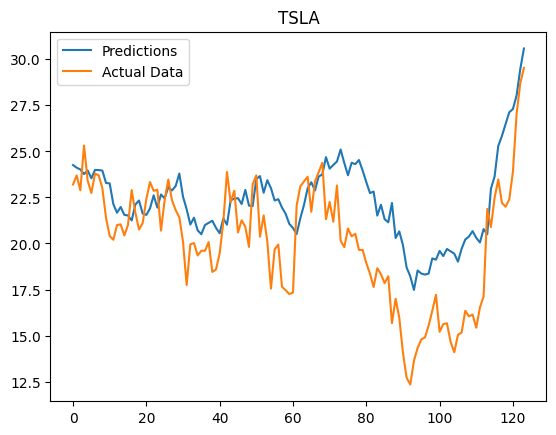

TSLA / Monthly :
Test MSE:  1.0094266813718624 Train MSE:  0.14066620979983208


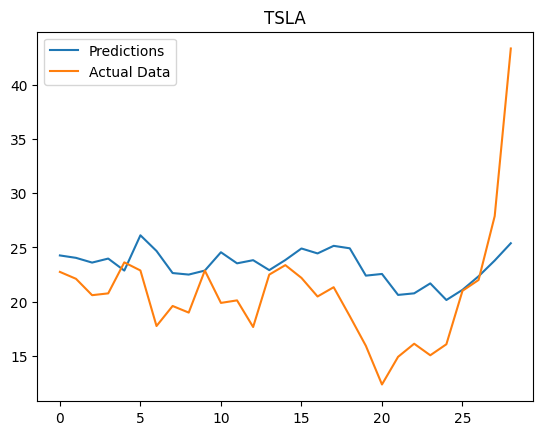

META / Daily :
Test MSE:  1.1609289170636674 Train MSE:  0.10843158167809783


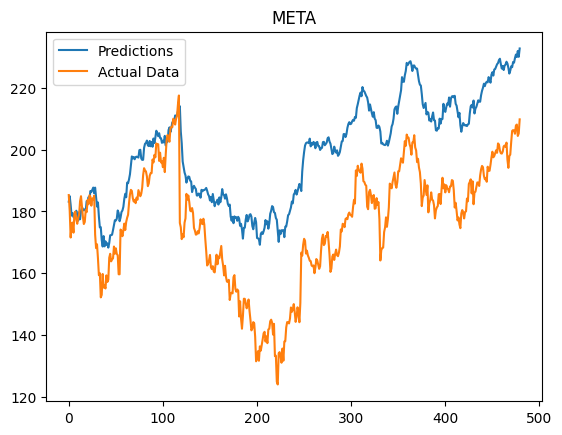

META / Weekly :
Test MSE:  3.008461253055982 Train MSE:  0.262773912182803


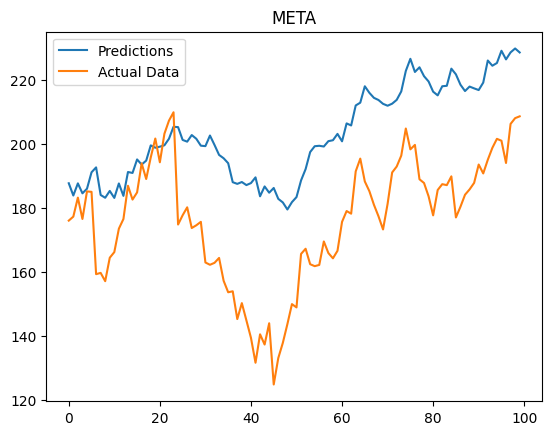

META / Monthly :
Test MSE:  4.422084287739247 Train MSE:  0.7320388620708452


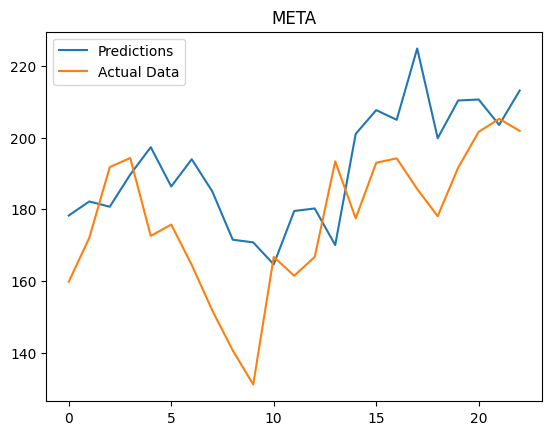

JNJ / Daily :
Test MSE:  0.34799626741186546 Train MSE:  0.054924325182667995


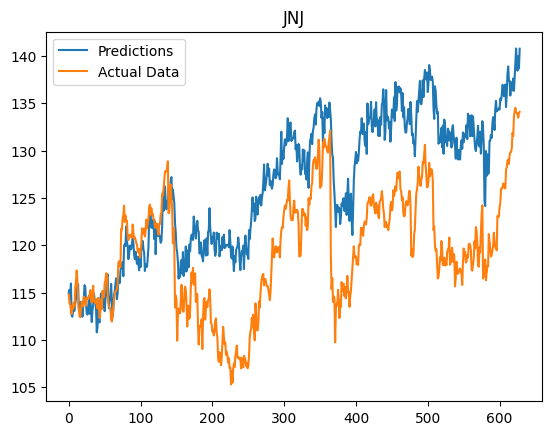

JNJ / Weekly :
Test MSE:  0.7050693236044624 Train MSE:  0.13076364896675896


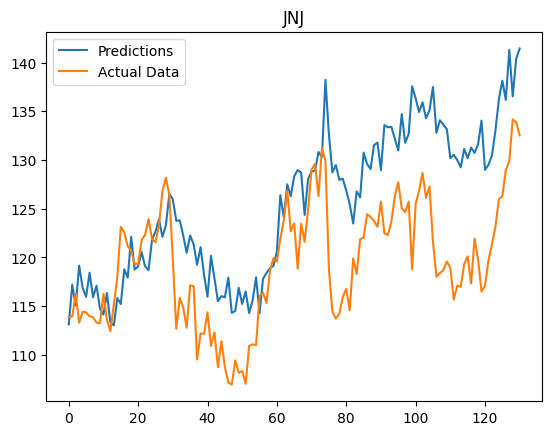

JNJ / Monthly :
Test MSE:  2.068250788308497 Train MSE:  0.29865492444622627


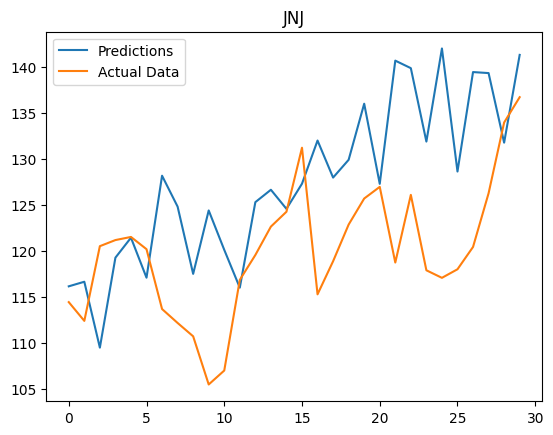

V / Daily :
Test MSE:  1.2551776999708986 Train MSE:  0.09386373398060711


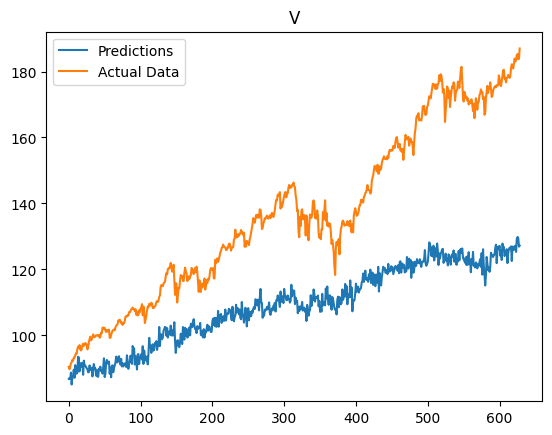

V / Weekly :
Test MSE:  3.3895194291459263 Train MSE:  0.22651021814008007


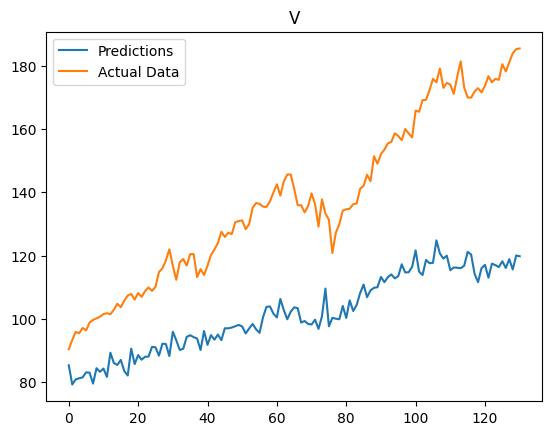

V / Monthly :
Test MSE:  8.138016177754706 Train MSE:  0.4207987483938066


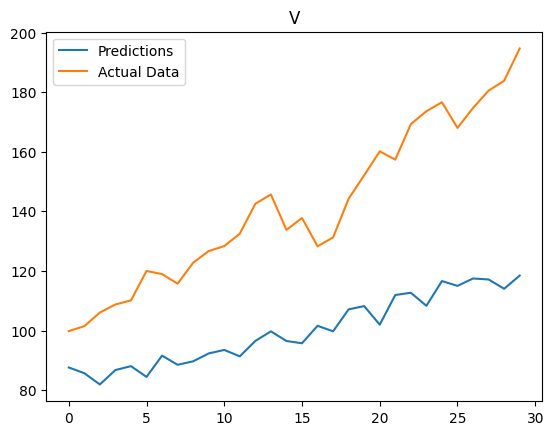

<Figure size 640x480 with 0 Axes>

In [19]:
import warnings
from sklearn.utils import extmath

def main():
    with warnings.catch_warnings():
        # Filter out the RuntimeWarning message
        warnings.filterwarnings("ignore", message="invalid value encountered in divide")
        stock_list = ['AAPL','MSFT','GOOG','AMZN','NVDA','BRK-B','TSLA','META','JNJ','V']
        freq_list = ['Daily','Weekly','Monthly']
        for stock in stock_list:
            for freq in freq_list:
                X,y = X_y(freq,stock)
                n_split = find_split(X,y)
                print(stock,"/",freq,":")
                plt.close()
                plt.figure()
                lasso(X,y,n_split,stock)
                plt.savefig('../plots/'+freq+'/'+stock+'.png', dpi = 300)
                # plt.clf()
                # plt.close()

main()